## Trabalho Prático 2 - Planejamento e Navegação

Utilizando a estratégia de planejamento de caminhos Roadmap, deve-se utilizar um robô Holonômico.

As carcterísticas de um robô holonômico são: 
- Possuem um número de velocidades atuáveis 

#### Instalando pacotes não habituais utilizados no código

In [1027]:
#pip install coppeliasim-zmqremoteapi-client

### Importando as bibliotecas

In [1028]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import networkx as nx
from coppeliasim_zmqremoteapi_client import *

### Remote API functions (Python)

Criação do cliente para conexão com a api remota

Link para repositório da SimZMQRemoteApi: https://github.com/CoppeliaRobotics/zmqRemoteApi/tree/master/clients/python

In [1029]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
robotino = sim.getObject('/robotino')
print("Printando o robotininho: " + str(robotino))

Printando o robotininho: 15


### Funções auxiliares

In [1030]:
# Função para rotacionar em torno do eixo z
# Função para criar matriz de rotação em torno do eixo Z
#def Rz(theta):
#    return np.array([
#        [np.cos(theta), -np.sin(theta), 0, 0],
#        [np.sin(theta), np.cos(theta), 0, 0],
#        [0, 0, 1, 0],
#        [0, 0, 0, 1]
#    ])
# Função para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

#### Carregando imagem do mapa

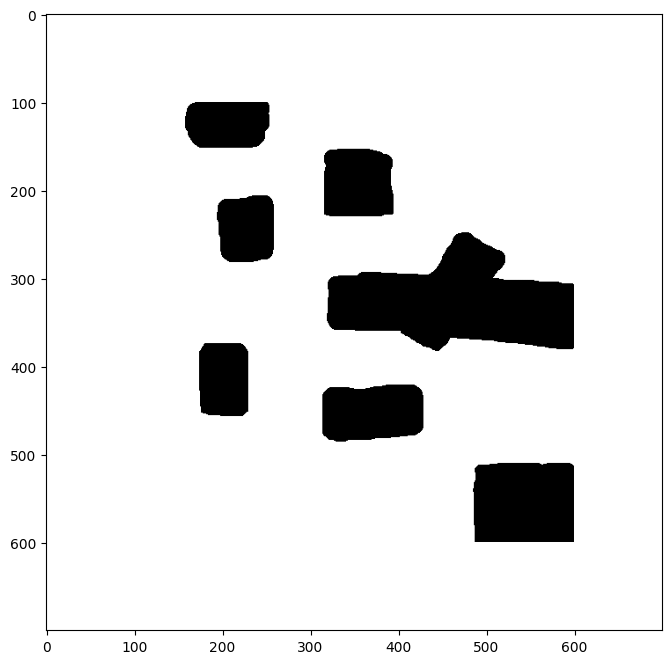

In [1031]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('cave.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

#### Criando o grid com as células binarizadas

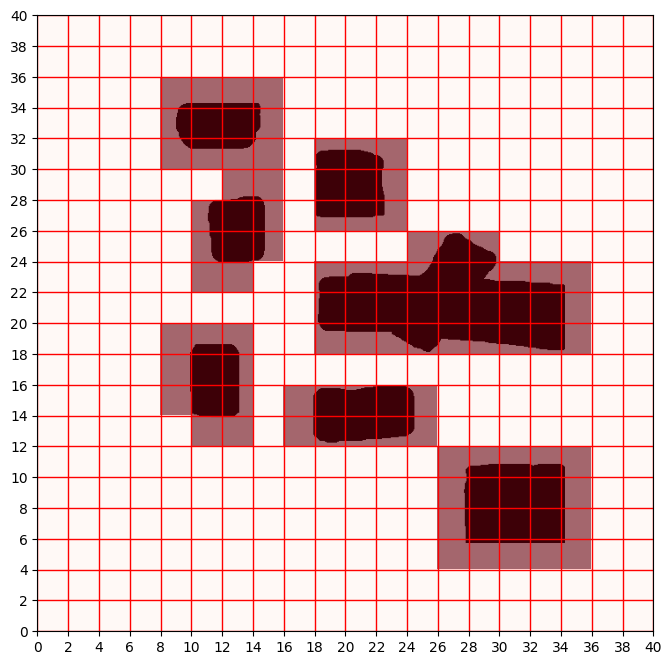

In [1032]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([40, 40]) # Cave 
#map_dims = np.array([22, 43])  # Maze

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

### Criando o Grafo para o Grid feito

Start: (0, 0)
End: (19, 19)


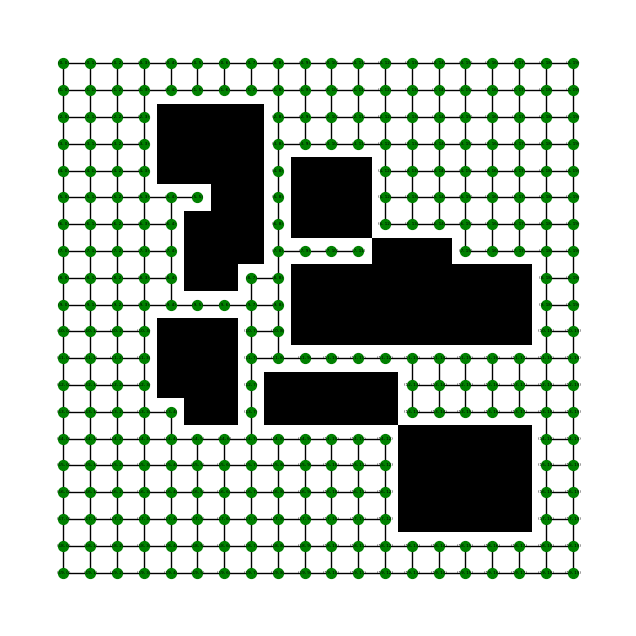

In [1033]:
# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 

# Removendo células que estão em células marcas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1:  
            G.remove_node((r,c))


fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Grid
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]))

ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

# Os vértices serão plotados no centro da célula  
pos = {node:(node[1]*cell_size+cell_size/2, map_dims[0]-node[0]*cell_size-cell_size/2) for node in G.nodes()}
nx.draw(G, pos, font_size=3, with_labels=True, node_size=50, node_color="g", ax=ax)

# Vértices de início e fim
start = (0,0)
end = (rows-1, cols-1)
print("Start:", start)
print("End:", end)

#### Determinando o melhor caminho

Path: [(1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (10, 7), (11, 7), (12, 7), (13, 7), (14, 7), (14, 8), (14, 9), (14, 10), (14, 11), (14, 12), (15, 12), (16, 12), (17, 12), (18, 12), (18, 13), (18, 14), (18, 15), (18, 16), (18, 17)]


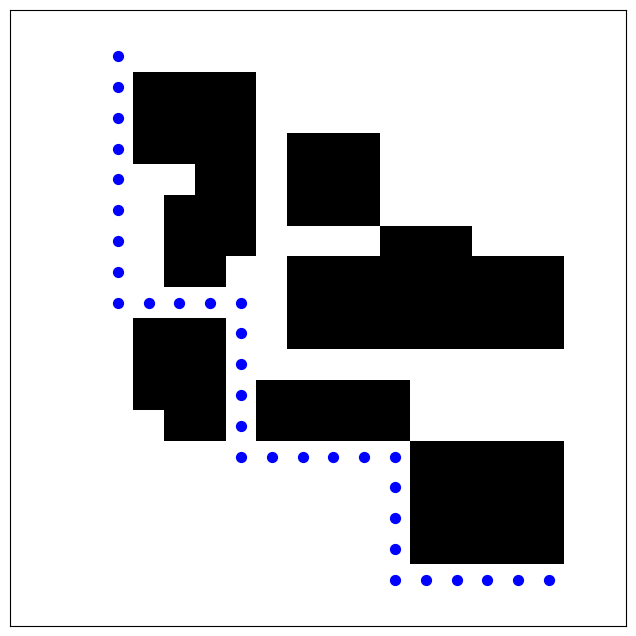

In [1034]:
# Cave
start_node =  (1, 3)
end_node = (18, 17) # Goal 1

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Mapa
obj = ax.imshow(grid, cmap='Greys', extent=(0, map_dims[1], 0,map_dims[0]))

# Caminho
path = nx.shortest_path(G, source=start_node, target=end_node)
nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=50, node_color='b')

print("Path:", path)

#### Convertendo para os referenciais da cena

Coppelia Path: [[-7  9]
 [-7  8]
 [-7  7]
 [-7  6]
 [-7  5]
 [-7  4]
 [-7  3]
 [-7  2]
 [-7  1]
 [-6  1]
 [-5  1]
 [-4  1]
 [-3  1]
 [-3  0]
 [-3 -1]
 [-3 -2]
 [-3 -3]
 [-3 -4]
 [-2 -4]
 [-1 -4]
 [ 0 -4]
 [ 1 -4]
 [ 2 -4]
 [ 2 -5]
 [ 2 -6]
 [ 2 -7]
 [ 2 -8]
 [ 3 -8]
 [ 4 -8]
 [ 5 -8]
 [ 6 -8]
 [ 7 -8]]
Goal ->  [17 18]
Goal Coppelia ->  [ 7 -8]


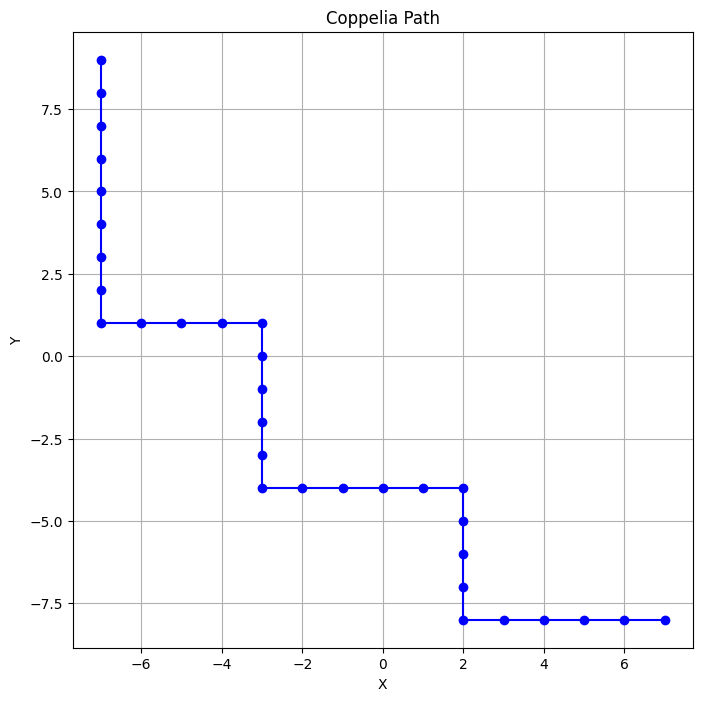

In [1035]:
# Convertendo para os referenciais da cena
path = np.asarray(path) # Convertendo para array numpy
#print("Path cru: ",path)
path[:, [1, 0]] = path[:, [0, 1]] # invertendo os eixos porque no mapa utilizamos os nós invertidos.

# Preciso fazer a transformação do referencial do grid para o referencial da cena
#pBorg = [10, 10]
# subtraindo o ponto de origem do grid
#path = path - pBorg
#print("Path: ", path)

#path = np.column_stack((path*cell_size+cell_size, np.zeros(len(path)))) # Convertendo para metros e adicionando a terceira coluna
#print("Path: ", path)


coppeliaPath = [10, 10] - path
for i in range(len(coppeliaPath)):
    coppeliaPath[i, 0] = coppeliaPath[i, 0] * (-1)

print("Coppelia Path:", coppeliaPath)

#printar a última posição do array de path
print("Goal -> ", path[-1])
print("Goal Coppelia -> ", coppeliaPath[-1])

# Plotando o caminho do coppelia
plt.figure(figsize=(8, 8))
plt.plot(coppeliaPath[:, 0], coppeliaPath[:, 1], marker='o', color='b')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Coppelia Path')
plt.grid(True)
plt.show() 
    

## Movimentação do robô

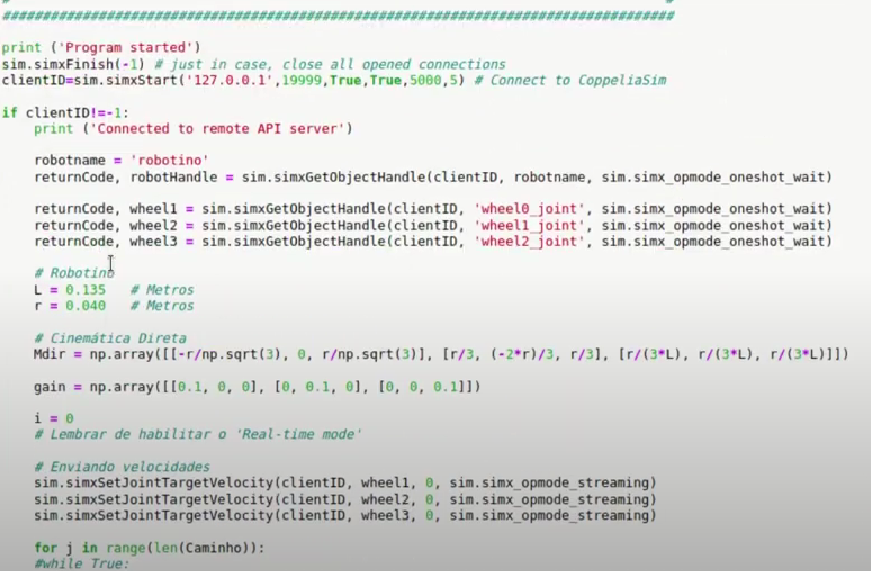
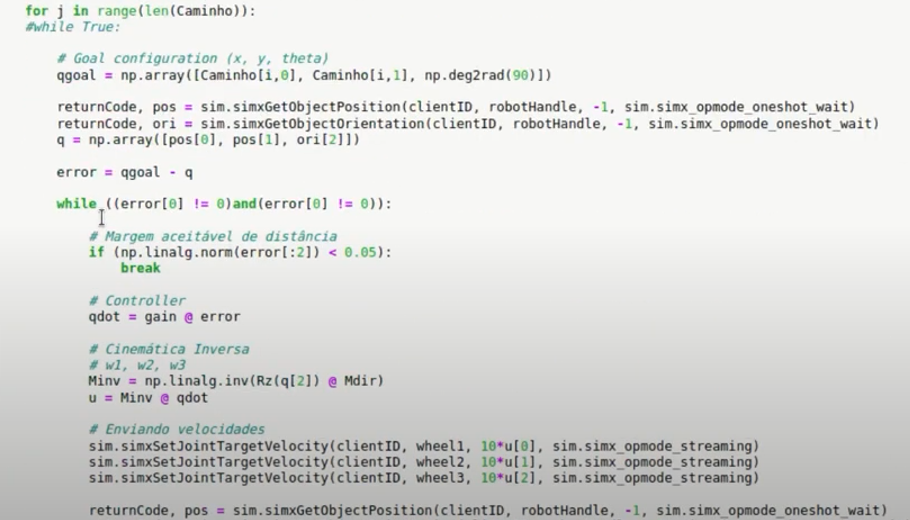
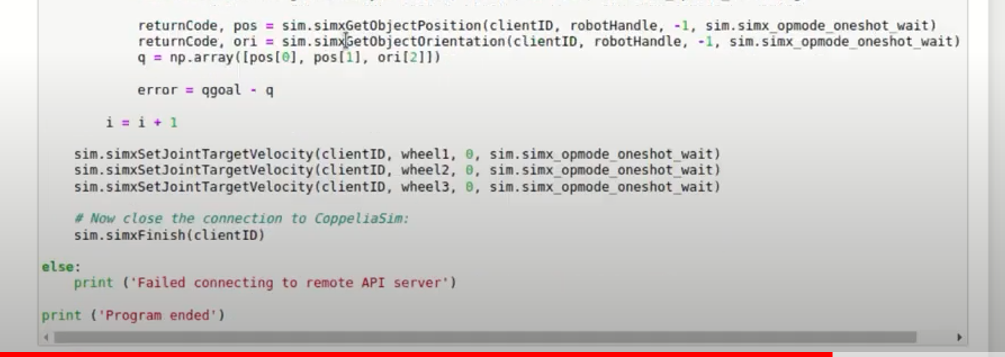

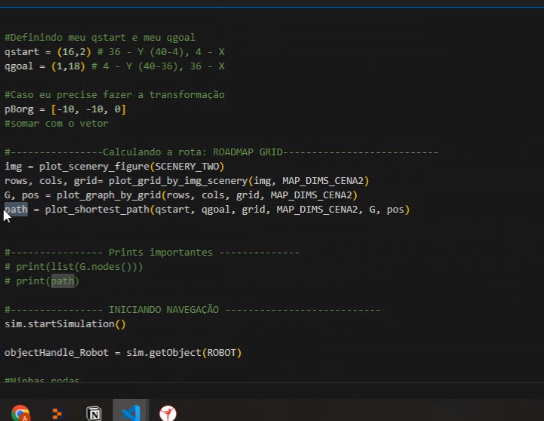

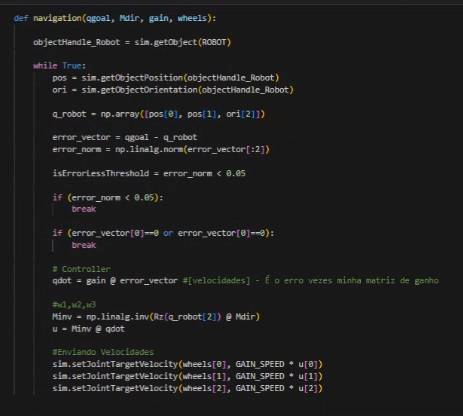

In [1036]:
# Conectando-se ao CoppeliaSim
# Run a simulation in asynchronous mode:
clientID = sim.startSimulation()


if clientID != -1:
    print("Connected to remote API server")

    # Get the robot's handle
    robotino = sim.getObjectHandle('/robotino')

    # Get the robot's wheels
    wheel1 = sim.getObjectHandle('wheel0_joint')
    wheel2 = sim.getObjectHandle('wheel1_joint')
    wheel3 = sim.getObjectHandle('wheel2_joint')

    # Retirado da aula 07 de navegação 
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
                       
    ganho = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]]) # Ganho do controlador

    # Adicione a coordenada Z se necessário (dependendo da sua aplicação)
    coppeliaPath = np.column_stack((coppeliaPath, np.zeros(len(coppeliaPath))))

for i in range(len(coppeliaPath)):
    # Posição do Robotino
    print("Goal: ", coppeliaPath[i])

    while True:
        # Posição inicial do Robotino em cena
        robotinoPos = get_object_position(sim, '/robotino')  #start
        robotinoOri = get_object_orientation(sim, '/robotino')
        
        q_robot = np.array([robotinoPos[0], robotinoPos[1], robotinoOri[2]])

        # Calcule o erro entre a posição atual e o próximo ponto do caminho
        error = coppeliaPath[i] - q_robot
        errorNorm = np.linalg.norm(error[:2])

        print("Coppelia: ", q_robot)
        print("Error: ", error)
        print("Error Norm: ", errorNorm)

        if errorNorm < 0.05:
            print("Goal reached")
            break

        # Calcule o vetor de controle usando o ganho e o erro
        qdot = ganho @ error

        # Calculando a velocidade linear e angular
        Minv = np.linalg.inv(Rz(q_robot[2]) @ Mdir)
        u = Minv @ qdot

        # Enviando velocidades para as rodas
        sim.setJointTargetVelocity(wheel1, 10 * u[0])
        sim.setJointTargetVelocity(wheel2, 10 * u[1])
        sim.setJointTargetVelocity(wheel3, 10 * u[2])

        # Atualizando a posição e orientação do robô
        robotinoPos = sim.getObjectPosition(robotino, -1)
        robotinoOri = sim.getObjectOrientation(robotino, -1)

    # Parando as rodas
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)

pos = sim.getObjectPosition(robotino, -1)
print(pos)

# Stop the simulation:
sim.stopSimulation()

Connected to remote API server
Goal:  [-7.  9.  0.]
Coppelia:  [-6.99408366e+00  8.99658643e+00  3.01443701e-03]
Error:  [-0.00591634  0.00341357 -0.00301444]
Error Norm:  0.006830486178468276
Goal reached
Goal:  [-7.  8.  0.]
Coppelia:  [-6.99049592e+00  8.99450665e+00  5.09062497e-03]
Error:  [-0.00950408 -0.99450665 -0.00509062]
Error Norm:  0.9945520647188268
Coppelia:  [-6.98601756e+00  8.98554275e+00  5.38485154e-03]
Error:  [-0.01398244 -0.98554275 -0.00538485]
Error Norm:  0.9856419305935477
Coppelia:  [-6.98022672e+00  8.95173251e+00 -4.27602738e-03]
Error:  [-0.01977328 -0.95173251  0.00427603]
Error Norm:  0.9519378958517617
Coppelia:  [-6.97713379  8.9174912  -0.01756181]
Error:  [-0.02286621 -0.9174912   0.01756181]
Error Norm:  0.9177760995113191
Coppelia:  [-6.97469527  8.87565151 -0.03612295]
Error:  [-0.02530473 -0.87565151  0.03612295]
Error Norm:  0.8760170640791262
Coppelia:  [-6.97275479  8.80188651 -0.07372663]
Error:  [-0.02724521 -0.80188651  0.07372663]
Error N